Anomaly at t=1.00s: Crash or HR distress detected (immediate alert)


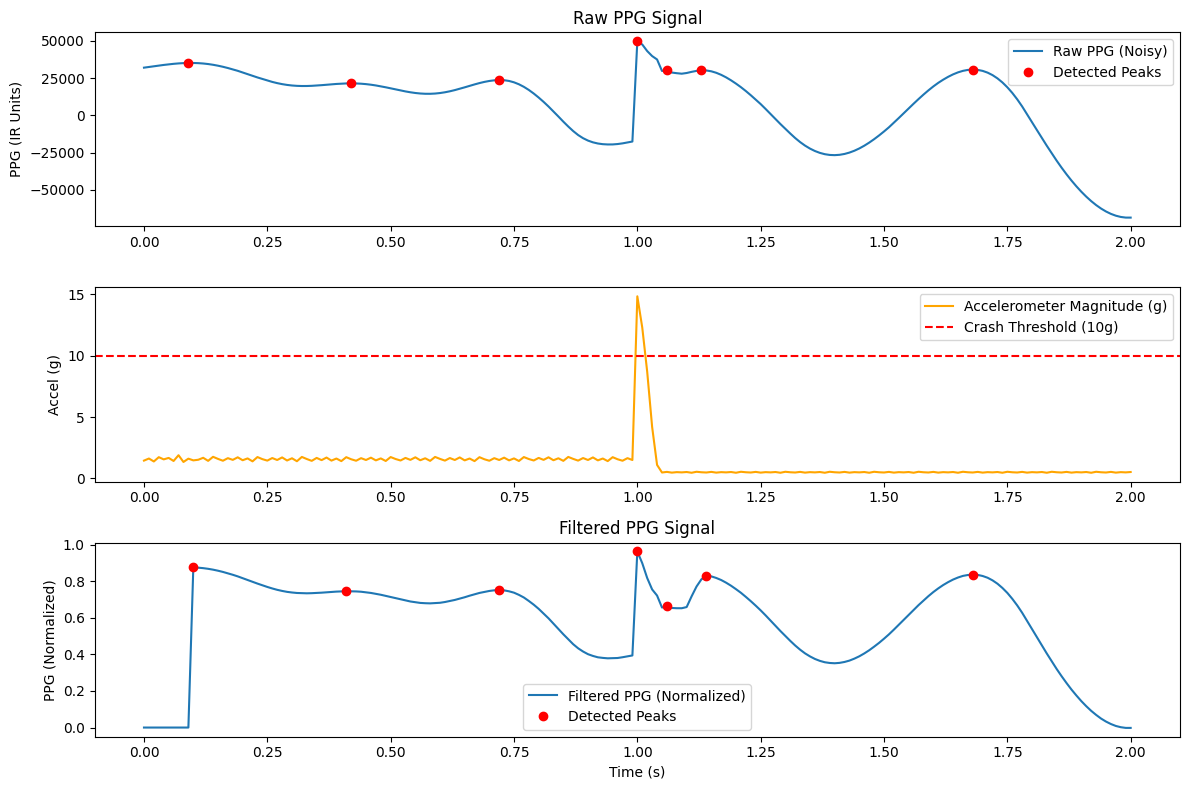

HR (Raw): 226.4 BPM
HR (Filtered): 227.8 BPM


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Data Collection (simulated via CSV)
# Assuming hehe.csv has 'time', 'ppg_ir', 'accel_mag' columns
data = pd.read_csv("hehe.csv")
time = data['time'].values  # Time in seconds (0 to 2s, 200 samples at 100 Hz)
raw_ppg = data['ppg_ir'].values  # PPG IR signal from MAX30100
accel_mag = data['accel_mag'].values  # Precomputed accelerometer magnitude

# Step 2: Preprocessing
# Normalization: Scale PPG and accelerometer data to 0-1 range
raw_ppg_normalized = (raw_ppg - raw_ppg.min()) / (raw_ppg.max() - raw_ppg.min())
accel_mag_normalized = (accel_mag - accel_mag.min()) / (accel_mag.max() - accel_mag.min())
# Note: Time alignment is implicit in CSV data

# Step 3: Adaptive Filtering (LMS)
def lms_filter(desired, reference, mu=0.01, filter_length=10):
    n_samples = len(desired)
    w = np.zeros(filter_length)
    filtered_signal = np.zeros(n_samples)
    
    for n in range(filter_length, n_samples):
        x_n = reference[n-filter_length:n][::-1]  # Reference input vector
        y_n = np.dot(w, x_n)  # Filter output
        e_n = desired[n] - y_n  # Error (filtered signal)
        w = w + mu * e_n * x_n  # Update weights
        filtered_signal[n] = e_n
    
    return filtered_signal

# Apply filter to normalized PPG
filtered_ppg_normalized = lms_filter(raw_ppg_normalized, accel_mag_normalized)

# Step 4: Heart Rate Extraction
def calculate_hr(signal, fs=100, threshold=0.5):
    peaks = []
    for i in range(1, len(signal)-1):
        if signal[i] > signal[i-1] and signal[i] > signal[i+1] and signal[i] > threshold:
            peaks.append(i)
    if len(peaks) >= 2:
        avg_period = np.mean(np.diff(peaks)) / fs  # Time between peaks in seconds
        hr = 60 / avg_period  # Beats per minute
        return peaks, hr
    return peaks, None

# Calculate HR (using normalized data)
peaks_raw, hr_raw = calculate_hr(raw_ppg_normalized, threshold=0.5)  # Adjusted for normalized range
peaks_filtered, hr_filtered = calculate_hr(filtered_ppg_normalized, threshold=0.5)

# Step 5: Anomaly Detection
def detect_anomaly(hr, accel_mag, time, hr_low=40, hr_high=150, accel_threshold=10, persistence=500):
    anomaly_count = 0
    anomaly_detected = False
    anomaly_time = None
    
    for t in range(len(accel_mag)):
        accel_condition = accel_mag[t] > accel_threshold  # Crash check (raw units)
        hr_condition = hr is not None and (hr < hr_low or hr > hr_high)  # HR anomaly
        
        if accel_condition or hr_condition:
            anomaly_count += 1
            if anomaly_count == 1:  # Record first detection
                anomaly_time = time[t]
            if anomaly_count >= persistence:  # 5 seconds at 100 Hz = 500 samples
                anomaly_detected = True
                break
        else:
            anomaly_count = 0  # Reset if condition clears
    
    return anomaly_detected, anomaly_time

# Check anomaly (using filtered HR and raw accel_mag)
anomaly_detected, anomaly_time = detect_anomaly(hr_filtered, accel_mag, time)

# Step 6: SOS Trigger (simulated)
if anomaly_detected:
    print(f"SOS Triggered at t={anomaly_time:.2f}s: Persistent anomaly detected (simulated GPS alert via ESP32)")
else:
    # Check for immediate crash or HR drop
    for t in range(len(filtered_ppg_normalized)):
        if accel_mag[t] > 10 or (t > 105 and filtered_ppg_normalized[t] < 0.4):  # Adjusted for normalized range
            print(f"Anomaly at t={time[t]:.2f}s: Crash or HR distress detected (immediate alert)")
            break

# Plot results (using raw units for readability)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, raw_ppg, label="Raw PPG (Noisy)")
plt.plot(time[peaks_raw], raw_ppg[peaks_raw], 'ro', label="Detected Peaks")
plt.legend()
plt.ylabel("PPG (IR Units)")
plt.title("Raw PPG Signal")

plt.subplot(3, 1, 2)
plt.plot(time, accel_mag, label="Accelerometer Magnitude (g)", color='orange')
plt.axhline(y=10, color='r', linestyle='--', label="Crash Threshold (10g)")
plt.legend()
plt.ylabel("Accel (g)")

plt.subplot(3, 1, 3)
plt.plot(time, filtered_ppg_normalized, label="Filtered PPG (Normalized)")
plt.plot(time[peaks_filtered], filtered_ppg_normalized[peaks_filtered], 'ro', label="Detected Peaks")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("PPG (Normalized)")
plt.title("Filtered PPG Signal")

plt.tight_layout()
plt.show()

# Output HR and anomaly status
print(f"HR (Raw): {hr_raw:.1f} BPM" if hr_raw else "HR (Raw): Not enough peaks")
print(f"HR (Filtered): {hr_filtered:.1f} BPM" if hr_filtered else "HR (Filtered): Not enough peaks")
if anomaly_detected:
    print(f"Persistent Anomaly Detected at t={anomaly_time:.2f}s")